In [1]:
# Sample USPTO to test coding with limited memory

# 09-23-19
# Marcelo sugeriu Reservoir Sampling

# 09-18-19
# Renato Kogeyama

In [2]:
import csv
import pandas as pd
import random
import itertools
import sys
import numpy as np


from sklearn import linear_model
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
from sklearn.metrics import roc_curve, auc
from scipy import stats
import datetime

In [3]:
# citation_file=r"patent_citation.csv"
# patents_file="patent.csv"
fname='df_w_pat_cit_190926.csv'
sample_df='sample_df_w_pat_cit_190926.csv'

In [4]:
# # dataset sample
# # inverte a logica: ao inves de dizer quais linhas deseja, indica quais nao deseja ver (skip)
# # informa essas linhas ao pd.read_csv

# %time
n = sum(1 for line in open(fname)) - 1 #number of records in file (excludes header)

In [5]:
s = 100000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv(fname, skiprows=skip, dtype={"id": object, "number": object})

In [6]:
# para quando rodar no servidor
# df = pd.read_csv(fname)

In [7]:
df.columns
#2001 Hall, Jaffe and Trajtenberg restrict the analysis to type:utility only. 
#They choose utility because is the vast majority of the papaents issued.

Index(['id', 'type', 'number', 'country', 'date', 'abstract', 'title', 'kind',
       'num_claims', 'filename', 'citation_id', 'year', 'month', 'day'],
      dtype='object')

In [8]:
# gera um output binario

df['citation_bi']=0
df.loc[df.citation_id>0, 'citation_bi']=1


In [9]:
# tamanho do dataset

nrow = len(df)
ncol = len(df.columns)

print('# of rows:', nrow)
print('# of columns:', ncol)

# of rows: 99989
# of columns: 15


In [10]:
# df3 - retirada dos outliers

df3=df

# preparacao para retirar outliers
# mean=df3.mean(axis=0)
# std_dev=df3.std(axis=0)

# threshold=3*std_dev.citation_id
# threshold=3*std_dev

df3=df3[df3.citation_id-df3['citation_id'].mean()<df3['citation_id'].std()*3]
df3=df3[df3.num_claims-df3['num_claims'].mean()<df3['num_claims'].std()*3]

df3.shape

(98021, 15)

In [11]:
df3.groupby(df3.year).mean()

,num_claims,citation_id,month,day,citation_bi
year,,,,,
1976,9.318966,0.013793,6.374138,15.915517,0.004310
1977,9.525501,0.006375,6.441712,15.843352,0.002732
1978,9.707556,0.001778,6.345778,15.739556,0.001778
1979,10.135366,0.013415,6.102439,15.615854,0.002439
1980,10.291871,0.006856,6.677767,15.923604,0.001959
1981,9.745917,0.018149,6.340290,15.675136,0.005445
1982,9.603175,0.005291,6.456085,15.377778,0.002116
1983,9.794055,0.003185,7.066879,15.319533,0.003185
1984,9.833184,0.008969,6.495964,15.844843,0.004484


In [29]:
df3[df3.year==2003].sort_values(by=['citation_id'], ascending=False)

,id,number,date,abstract,title,num_claims,filename,citation_id,year,month,...,kind_B1,kind_B2,kind_E,kind_E1,kind_H,kind_H1,kind_P,kind_P2,kind_P3,country_US
44101,6565244,6565244,2003-05-20,An identification light bar as required by 49 ...,Single source identification light bar,29.0,pg030520.zip,14.0,2003,5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45089,6627309,6627309,2003-09-30,The invention describes a method of curing a p...,Adhesive detackification,7.0,pg030930.zip,14.0,2003,9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44916,6616498,6616498,2003-09-09,A bubble generating assembly has a housing wit...,Bubble generating assembly,22.0,pg030909.zip,14.0,2003,9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44787,6608875,6608875,2003-08-19,A clock recovery system includes a source of a...,Free-running-frequency adjustment circuit for ...,21.0,pg030819.zip,14.0,2003,8,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44761,6606959,6606959,2003-08-19,Spaced cambered wedges having flow diverting s...,High speed drag reducing ventilation for marin...,11.0,pg030819.zip,14.0,2003,8,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44618,6597888,6597888,2003-07-22,The present invention provides an image heatin...,Image heating apparatus with holding a driving...,18.0,pg030722.zip,14.0,2003,7,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44573,6595690,6595690,2003-07-22,A reclosable package is provided having a fron...,Shock resistant tamper evident reclosable plas...,3.0,pg030722.zip,14.0,2003,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45005,6622192,6622192,2003-09-16,This invention relates to a method of shutting...,Method of shutting down a server in safety,12.0,pg030916.zip,14.0,2003,9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44555,6594460,6594460,2003-07-15,In a printing system in which a rotatable prin...,Low force lateral photoreceptor or intermediat...,7.0,pg030715.zip,14.0,2003,7,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45020,6623032,6623032,2003-09-23,An occupant restraint assembly and for a motor...,Belt force sensor,15.0,pg030923.zip,14.0,2003,9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
# converte categorias em dummies

df3=pd.get_dummies(df3, columns=['type', 'kind', 'country'])

In [13]:
# Check the Dataset
def uniqueColValues(auxdf):
    for column in auxdf:
        print("{} | {} | {}".format(
            auxdf[column].name, len(auxdf[column].unique()), auxdf[column].dtype
        ))
        
uniqueColValues(df3)

id | 98021 | object
number | 98021 | object
date | 2191 | object
abstract | 97737 | object
title | 95078 | object
num_claims | 50 | float64
filename | 2191 | object
citation_id | 15 | float64
year | 42 | int64
month | 12 | int64
day | 31 | int64
citation_bi | 2 | int64
type_plant | 2 | float64
type_reissue | 2 | float64
type_statutory invention registration | 2 | float64
type_utility | 2 | float64
kind_A | 2 | float64
kind_B1 | 2 | float64
kind_B2 | 2 | float64
kind_E | 2 | float64
kind_E1 | 2 | float64
kind_H | 2 | float64
kind_H1 | 2 | float64
kind_P | 2 | float64
kind_P2 | 2 | float64
kind_P3 | 2 | float64
country_US | 1 | float64


In [14]:
#exibe os graficos
%matplotlib inline 


In [15]:
df.groupby(df.kind).count().id

kind
A     40209
B1     9559
B2    49451
E       142
E1      166
H        33
H1        4
P       136
P2      201
P3       88
Name: id, dtype: int64

In [16]:
values=list(df.groupby(df.kind).count().id)

In [17]:
values

[40209, 9559, 49451, 142, 166, 33, 4, 136, 201, 88]

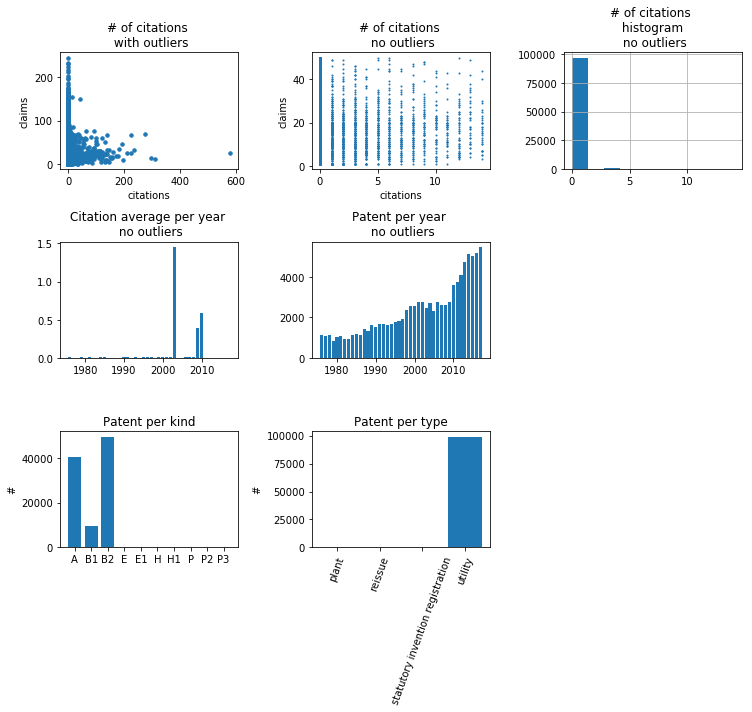

In [18]:
plot.figure(figsize=(14,10)) # You can think of the figure object as a canvas that holds all the subplots and other plot elements inside it.

plot.subplot(3, 4, 1)
plot.title('# of citations \n with outliers')
plot.xlabel('citations') 
plot.ylabel('claims') 
plot.scatter(df['citation_id'], df['num_claims'], s=12)

plot.subplot(3, 4, 2)
plot.title('# of citations \n no outliers')
plot.xlabel('citations') 
plot.ylabel('claims') 
plot.scatter(df3['citation_id'], df3['num_claims'], s=1)

plot.subplot(3, 4, 3)
plot.title('# of citations \n histogram \n no outliers')
df3.citation_id.hist()

plot.subplot(3, 4, 5)
plot.title('Citation average per year \n no outliers')
plot.bar(df3.groupby(df3.year).mean().citation_id.index, df3.groupby(df3.year).mean().citation_id)

plot.subplot(3, 4, 6)
plot.title('Patent per year \n no outliers')
plot.bar(df3.groupby(df3.year).mean().citation_id.index, df3.groupby(df3.year).count().id)

# per kind
names=list(df.groupby(df.kind).count().id.keys())
y_pos = np.arange(len(names))
values=list(df.groupby(df.kind).count().id)

plot.subplot(3, 4, 9)
plot.bar(y_pos, values)
plot.xticks(y_pos, names)
plot.ylabel('#')
plot.title('Patent per kind')

# per type
names=list(df.groupby(df.type).count().id.keys())
y_pos = np.arange(len(names))
values=list(df.groupby(df.type).count().id)

# per kind
plot.subplot(3, 4, 10)
plot.bar(y_pos, values)
plot.xticks(y_pos, names, rotation=70)
plot.ylabel('#')
plot.title('Patent per type')

plot.tight_layout()

In [19]:
# tricks with groupby

# df3.groupby(df3.year).describe() #basic stats per year
# df3.groupby(df3.year).mean().citation_id #average citation per year


In [20]:
# # # Naive Bayes
# def test_naive_bayes(dataset):

# #     chosenColumns = ['num_claims','year', 'type_plant',
# #            'type_reissue', 'type_statutory invention registration', 'type_utility',
# #            'kind_A', 'kind_B1', 'kind_B2', 'kind_E', 'kind_E1', 'kind_H', 'kind_P',
# #            'kind_P2', 'kind_P3']
#     chosenColumns = ['num_claims','year']

#     myX = dataset.as_matrix(columns=chosenColumns)
#     # myY = df2.as_matrix(columns=['citation_id'])
#     myY = dataset.as_matrix(columns=['citation_id'])

#     xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
#     testSize = yTest.shape[0]


#     # nb = naive_bayes.GaussianNB()

#     # dado que o output eh count, uma distribuicao multinomial se adapta melhor
#     nb = naive_bayes.MultinomialNB()

#     # complementNB adapta o MultinomialNB para datasets muito desbalanceados
#     # porem nao esta disponivel para a versao 0.19 do scikit-learn
#     # nb = naive_bayes.ComplementNB()

#     nb.fit(xTrain, yTrain.ravel())

#     yPredNB = nb.predict(xTest) # predicting test data

#     # computing error
#     errorNB = np.sum((yPredNB[i] != yTest[i]) for i in range(0, testSize))
#     errorNBPCT = int(100*errorNB/testSize)
#     hitRateNBPCT = 100 - errorNBPCT
#     return(testSize, errorNB, errorNBPCT, hitRateNBPCT)
   

In [21]:
# #naive bayes with complete dataset

# testSize, errorNB, errorNBPCT, hitRateNBPCT=test_naive_bayes(df)

# print("----------Naive Bayes----------")
# print(int(errorNB), "misclassified data out of", testSize)
# print("Error PCT: ",errorNBPCT,'%')
# print("Hit Rate:  ",hitRateNBPCT,'%')

In [22]:
# #naive bayes without outliers

# testSize, errorNB, errorNBPCT, hitRateNBPCT=test_naive_bayes(df3)

# print("----------Naive Bayes----------")
# print(int(errorNB), "misclassified data out of", testSize)
# print("Error PCT: ",errorNBPCT,'%')
# print("Hit Rate:  ",hitRateNBPCT,'%')

In [23]:
# # K Nearest Neighbors

# chosenColumns = ['num_claims','year']

# myX = df.as_matrix(columns=chosenColumns)
# # myY = df2.as_matrix(columns=['citation_id'])
# myY = df.as_matrix(columns=['citation_bi'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
# testSize = yTest.shape[0]
    
# myK = 5

# knn =  KNeighborsClassifier(n_neighbors=myK)
# knn.fit(xTrain, yTrain.ravel())
# yPredKNN = knn.predict(xTest) # predicting test data

# # computing error
# errorKNN = np.sum((yPredKNN[i] != yTest[i]) for i in range(0, testSize))
# errorKNNPCT = int(100*errorKNN/testSize)
# hitRateKNNPCT = 100 - errorKNNPCT

# print("----------K Nearest Neighbors----------")
# print(int(errorKNN), "misclassified data out of", testSize)
# print("Error PCT: ",errorKNNPCT,'%')
# print("Hit Rate:  ",hitRateKNNPCT,'%')

In [24]:
# # Constructing the ROC curve and AUC

# fpr, tpr, thresh = roc_curve(yTest.ravel(), yPredKNN.ravel())
# rocAuc = auc(fpr, tpr)

In [25]:
# # Plotting Everything

# plot.figure()
# lw = 2
# plot.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % rocAuc)
# plot.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plot.xlim([0.0, 1.0])
# plot.ylim([0.0, 1.05])
# plot.xlabel('False Positive Rate')
# plot.ylabel('True Positive Rate')
# plot.title('Receiver operating characteristic example')
# plot.legend(loc="lower right")
# plot.show()